# Filter out non car images

Some images show not a whole car but only it's interior, or some separate part of a car, which may not be enough to reliably predict price.
\
To filter out this images I used pretrained `VGG16` model adding single dense layer after convolutions.

## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Load data

In [3]:
!ls ../datasets/autoria/classification

car
not_car


In [4]:
cars_dir = Path('../datasets/autoria/classification/car')
not_cars_dir = Path('../datasets/autoria/classification/not_car')

In [5]:
def load_images(paths):
    images = []
    
    for path in paths:
        image = keras.preprocessing.image.load_img(path)# color_mode = "grayscale")
        image = keras.preprocessing.image.img_to_array(image)
        image = keras.preprocessing.image.smart_resize(image, (250, 380))
        image = tf.image.resize(image, (224, 224))
        images.append(image)
        
    return tf.stack(images)

In [6]:
cars = load_images(cars_dir.iterdir())
not_cars = load_images(not_cars_dir.iterdir())

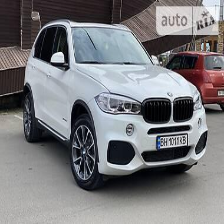

In [7]:
keras.preprocessing.image.array_to_img(cars[2])

In [8]:
cars.shape, not_cars.shape

(TensorShape([64, 224, 224, 3]), TensorShape([64, 224, 224, 3]))

In [60]:
labels_shape = (64, )
cars_labels = np.ones(labels_shape)
not_cars_labels = np.zeros(labels_shape)

In [61]:
X = tf.concat([cars, not_cars], axis=0)
y = np.concatenate([cars_labels, not_cars_labels], axis=0)

X.shape, y.shape

(TensorShape([128, 224, 224, 3]), (128,))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y, test_size=0.2, random_state=5)

In [63]:
X_train.shape, X_test.shape

((102, 224, 224, 3), (26, 224, 224, 3))

In [83]:
np.expand_dims(X_train[0], 0).shape

(1, 224, 224, 3)

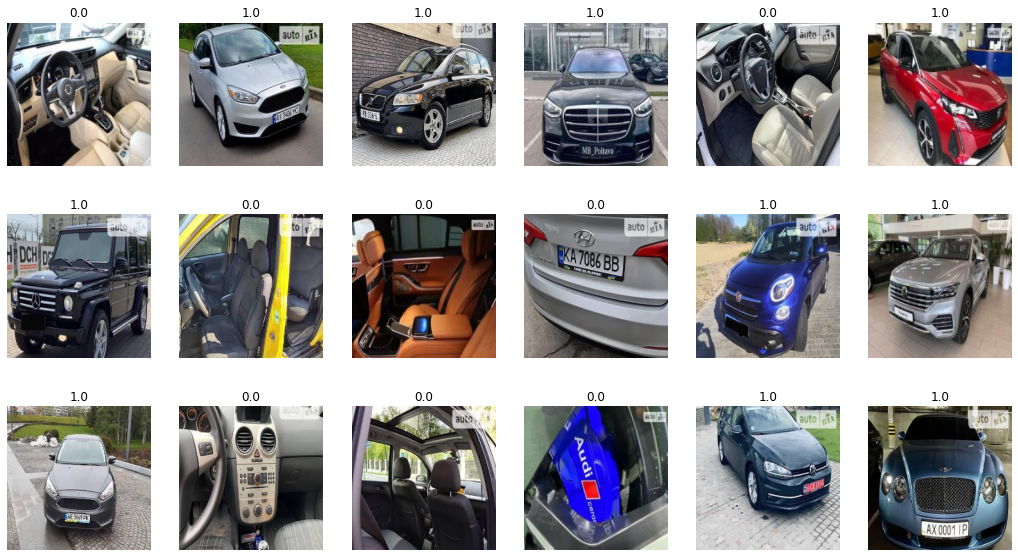

In [89]:
plt.figure(figsize=(18, 10))
for i, (img, lbl) in enumerate(zip(X_test[:18], y_test[:18])):
    ax = plt.subplot(3, 6, i + 1)
    ax.imshow(img / 255,)
    ax.set_title(lbl)
    ax.axis('off')

## Traning model

In [78]:
# Feature extraction
conv_base = keras.applications.vgg16.VGG16(include_top=False,
                                           input_shape=(224, 224, 3))
conv_base.trainable = False

In [116]:
def get_model():
    data_augmentation = keras.Sequential([
        layers.experimental.preprocessing.RandomRotation(0.05),
        layers.experimental.preprocessing.RandomZoom(0.2)
    ])

    inputs = keras.Input(shape=X_train.shape[1:])
    x = data_augmentation(inputs)
    x = conv_base(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)
    return model

In [117]:
model = get_model()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129 

In [99]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, 
          batch_size=16,
          epochs=10,
          validation_data=(X_test, y_test))

Epoch 1/10
7/7 [==============================] - 23s 712ms/step - loss: 13.5791 - accuracy: 0.6481 - val_loss: 6.0197 - val_accuracy: 0.9615
Epoch 2/10
7/7 [==============================] - 1s 87ms/step - loss: 1.4344 - accuracy: 0.9646 - val_loss: 1.2213e-14 - val_accuracy: 1.0000
Epoch 3/10
7/7 [==============================] - 1s 86ms/step - loss: 1.4807 - accuracy: 0.9765 - val_loss: 1.0446 - val_accuracy: 0.9615
Epoch 4/10
7/7 [==============================] - 1s 89ms/step - loss: 0.7746 - accuracy: 0.9877 - val_loss: 1.9510 - val_accuracy: 0.9615
Epoch 5/10
7/7 [==============================] - 1s 87ms/step - loss: 0.4892 - accuracy: 0.9909 - val_loss: 0.1000 - val_accuracy: 0.9615
Epoch 6/10
7/7 [==============================] - 1s 90ms/step - loss: 2.4572e-17 - accuracy: 1.0000 - val_loss: 1.4583 - val_accuracy: 0.9615
Epoch 7/10
7/7 [==============================] - 1s 86ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.1324 - val_accuracy: 0.9615
Epoch 8/10
7

In [104]:
y_pred = model.predict(X_test)

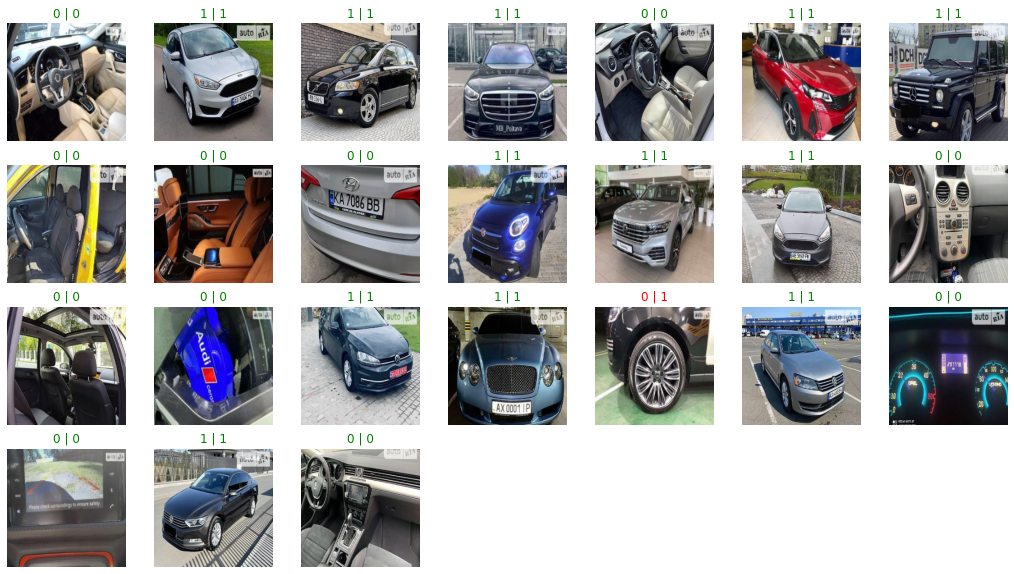

In [111]:
plt.figure(figsize=(18, 10))
for i, (img, ytrue, ypred) in enumerate(zip(X_test[:24], y_test, y_pred)):
    ax = plt.subplot(4, 7, i + 1)
    ax.imshow(img / 255,)
    ytrue = int(ytrue)
    ypred = int(ypred[0])
    if ytrue != ypred:
        ax.set_title(f'{ytrue} | {ypred}', fontdict={'color': 'red'})
    else:
        ax.set_title(f'{ytrue} | {ypred}', fontdict={'color': 'green'})
    ax.axis('off')

### Train on all data and save model

In [121]:
X.shape, y.shape

(TensorShape([128, 224, 224, 3]), (128,))

In [122]:
model = get_model()
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [123]:
model.fit(X, y, 
          batch_size=16,
          epochs=3,)

Epoch 1/3
8/8 [==============================] - 2s 55ms/step - loss: 10.3490 - accuracy: 0.7315
Epoch 2/3
8/8 [==============================] - 0s 53ms/step - loss: 1.1925 - accuracy: 0.9633
Epoch 3/3
8/8 [==============================] - 0s 52ms/step - loss: 1.5984 - accuracy: 0.9833


In [125]:
model.save('../models/image_cleaning')

INFO:tensorflow:Assets written to: ../models/image_cleaning\assets


## Cleaning image dataset

In [3]:
model = keras.models.load_model('../models/image_cleaning')

In [4]:
df = pd.read_csv('../datasets/autoria/autoria_encoded_data.csv', index_col=0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129292 entries, 0 to 146813
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   brand              129292 non-null  int64  
 1   fuel_type          129292 non-null  int64  
 2   transmission_type  129292 non-null  int64  
 3   price_USD          129292 non-null  int64  
 4   mileage_kkm        129292 non-null  int64  
 5   year_made          129292 non-null  int64  
 6   engine_size        129292 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 7.9 MB


In [3]:
car_path = Path('../datasets/autoria/car_images')
not_car_path = Path('../datasets/autoria/not_car_images')

os.makedirs(car_path, exist_ok=True)
os.makedirs(not_car_path, exist_ok=True)

In [7]:
def load_image(path): 

    image = keras.preprocessing.image.load_img(path)
    image = keras.preprocessing.image.img_to_array(image)
    image = keras.preprocessing.image.smart_resize(image, (250, 380))
    image = tf.image.resize(image, (224, 224))
    
    return image


image_paths = Path('../datasets/autoria/images').iterdir()

for count, path in enumerate(image_paths):
    image = load_image(path)
    car_id, brand = path.name.split('_')[:2]
    car_id = int(car_id)
    
    try:
        data = df.loc[car_id]
    except KeyError:
        continue
    
    brand_code = data['brand']
    fuel_type = data['fuel_type']
    transmission_type = data['transmission_type']
    price = data['price_USD']
    mileage = data['mileage_kkm']
    year_made = data['year_made']
    engine_size = data['engine_size']
    
    new_name = "{0}_{1}_{2}_{3}_{4}_{5}_{6}_{7}_{8}.jpg".format(
        car_id,
        price,
        brand_code,
        fuel_type,
        transmission_type,
        mileage,
        year_made,
        engine_size,
        brand,
    )
    # don't use predict, it creates a memory leak
    image_is_car = model(tf.expand_dims(image, 0))[0, 0]
    
    if image_is_car:
        keras.preprocessing.image.save_img(car_path/new_name, image)
    else:
        keras.preprocessing.image.save_img(not_car_path/new_name, image)
    
    if count % 100 == 0:
        print(f"Done: {count}", end='\r')

In [9]:
not_car_paths = list(not_car_path.iterdir())
len(not_car_paths)

6126

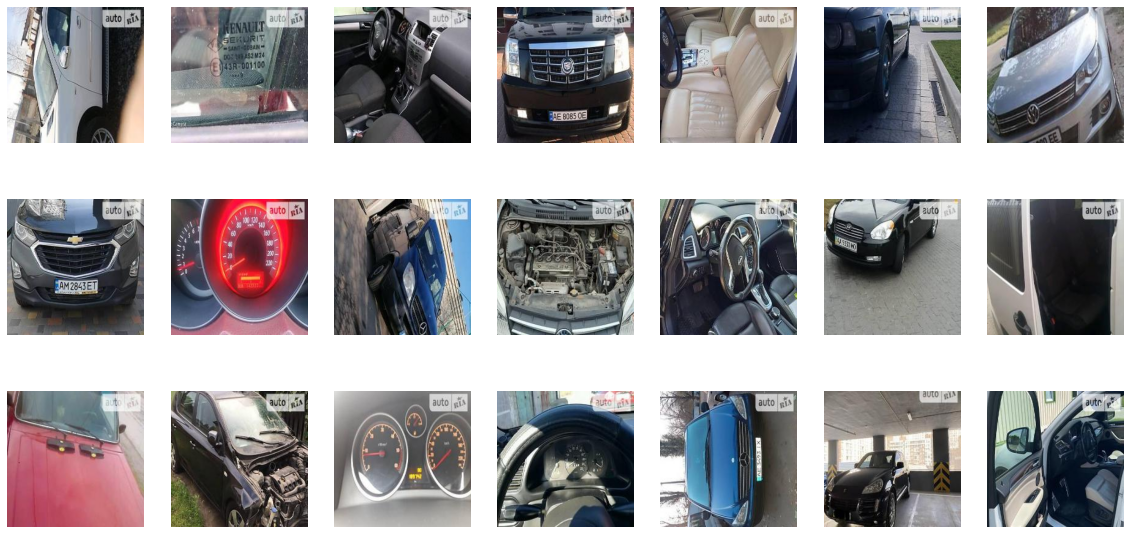

In [23]:
plt.figure(figsize=(20, 10))
for i, p in enumerate(not_car_paths[200:221]):
    ax = plt.subplot(3, 7, i + 1)
    im = keras.preprocessing.image.load_img(p)
    ax.imshow(im)
    ax.axis('off')